In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# import sigpy.plot as pl

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

import numpy as np
import SimpleITK as sitk

import subtle.utils.io as suio
import subtle.utils.experiment as exp_utils
import subtle.subtle_preprocess as sup
import subtle.subtle_preprocess as supre

from skimage.morphology import binary_closing
from skimage import color

import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from glob import glob
import pydicom

def get_rgb(img):
    img = (img - np.min(img))/np.ptp(img)
    return np.dstack((img, img, img))

def overlay_rgb(base_vol, ovr_vol, sl_idx, ch_idx=0, alpha=0.5):
    img_a = get_rgb(base_vol[sl_idx])
    img_b = get_rgb(ovr_vol[sl_idx])
    
    img_a[..., ch_idx] = img_b[..., 0] * alpha
    return img_a
    
def slice_preview(img_vol, interval=7, disp=True):
    n_rows = 7
    n_cols = 6
    idx = interval
    all_imgs = []
    bflag = False
    for c in range(n_cols):
        img_rows = []
        for r in range(n_rows):
            if idx >= img_vol.shape[0]:
                img_rows.append(np.zeros_like(img_vol[0]))
                bflag = True
            else:
                img_rows.append(img_vol[idx])
            idx += interval
                
        all_imgs.append(np.hstack(img_rows))
        if bflag:
            break
    
    img_disp = np.vstack(all_imgs)
    
    if not disp:
        return img_disp
    
    plt.imshow(img_disp)
    plt.axis('off')
    plt.show()

def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))])
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

In [9]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/data/Patient_0225/10_AX_T2_+C'
t2_vol, hdr = suio.dicom_files(base_path)
print('t2 shape', t2_vol.shape)

t2_spacing = np.array([float(hdr.PixelSpacing[0]), float(hdr.PixelSpacing[1]), float(hdr.SliceThickness)])

data_full = np.load('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0225.npy')
print(data_full.shape)
t1_pre = data_full[0, :, 0]
t1_meta = suio.load_h5_metadata('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0225_meta.h5')

t2 shape (32, 512, 512)
(2, 376, 3, 512, 512)


In [7]:
pmap = sitk.GetDefaultParameterMap('rigid')
ref_fixed = supre.dcm_to_sitk('/home/srivathsa/projects/studies/gad/stanford/data/Patient_0225/15_AX_BRAVO_+C_Pre_Load_10')
ref_moving = supre.dcm_to_sitk(base_path)

fixed_spacing = t1_meta['pixel_spacing_zero']
t2_reg, reg_params = supre.register_im(t1_pre, t2_vol, param_map=pmap, im_fixed_spacing=fixed_spacing, 
                                       im_moving_spacing=t2_spacing, ref_fixed=ref_fixed, ref_moving=ref_moving)

image registration
registration done, 6.16 s


In [12]:
print(t1_pre.min(), t1_pre.max())
print(t2_reg.min(), t2_reg.max())
t2_sc = np.interp(t2_reg, (t2_reg.min(), t2_reg.max()), (t1_pre.min(), t1_pre.max()))
# plt.imshow(t2_sc[150])
# plt.colorbar()

0.0 11.855304
0.0 6087.844


In [13]:
nse_mask = supre.mask_im(np.array([t2_reg]))[0]
t2_nse = nse_mask * t2_reg

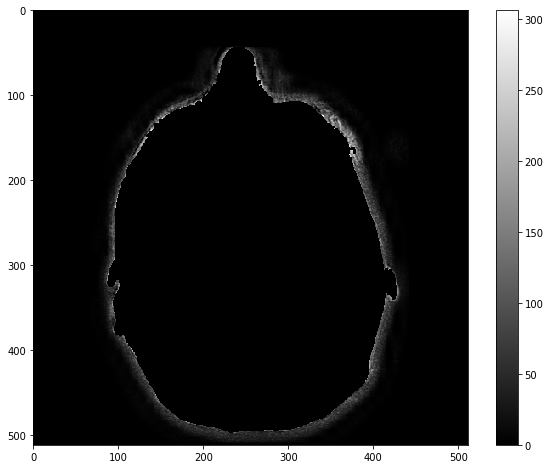

In [14]:
plt.imshow(t2_reg[150] - t2_nse[150])
plt.colorbar()

(3072, 3584)


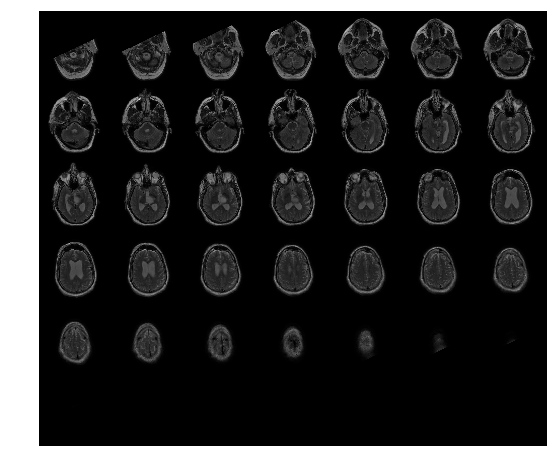

In [111]:
slice_preview(t2_reg)

In [59]:
suio.write_dicoms('/home/srivathsa/projects/studies/gad/stanford/data/Patient_0187/8_AX_BRAVO', t2_reg, 
             '/home/srivathsa/projects/T2_REG_Patient_0187', series_desc_pre='', series_desc_post='T2_REG')

100%|██████████| 364/364 [00:04<00:00, 80.87it/s]


In [15]:
mask = data_full[1, :, 2] > 0.1
mask = binary_closing(mask)

t2_m = t2_reg * mask

1390.4607421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


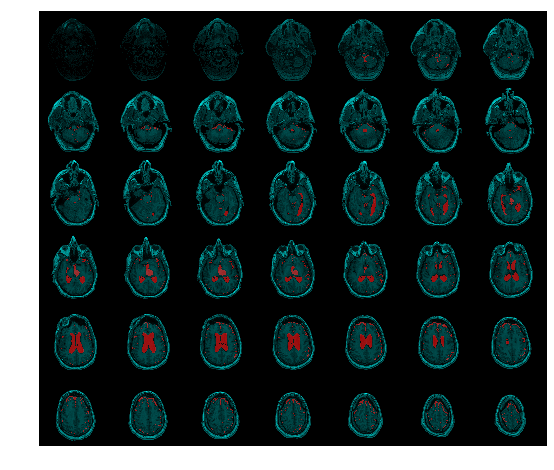

In [16]:
qnts = np.quantile(t2_reg[mask], 0.9)
print(qnts)
t2_th = (t2_m >= qnts).astype(t1_pre.dtype)

t1_disp = slice_preview(t1_pre, disp=False)
csf_disp = slice_preview(t2_th, disp=False)

t1_rgb = get_rgb(t1_disp)
csf_rgb = get_rgb(csf_disp)

t1_rgb[..., 0] = csf_rgb[..., 0] * 0.5

disp_scale = 1.2
plt.imshow(disp_scale * t1_rgb, vmin=t1_pre.min(), vmax=t1_pre.max())
plt.axis('off')
plt.savefig('t2_csf.png')

# disp = overlay_rgb(t1_pre, t2_th, sl_idx=182, ch_idx=0)


# plt.imshow(disp_scale * disp, vmin=disp.min(), vmax=disp.max())

In [141]:
df_t2qc = pd.read_csv('/home/srivathsa/projects/studies/gad/stanford/t2_qc.csv')
src_path = '/raid/SubtleGAD_Stanford/lowcon'
dest_path = '/home/srivathsa/projects/studies/gad/stanford/data'
for idx, row in df_t2qc.iterrows():
    if 'T2' not in row['scan']:
        continue
    case_num = 'Patient_{:04d}'.format(row['subject'])
    t2_path = '{}/{}/{}'.format(src_path, case_num, row['scan'])
    target_path = '{}/{}/{}'.format(dest_path, case_num, row['scan'])
    if not os.path.exists('{}/{}'.format(dest_path, case_num)):
        continue
    if not os.path.exists(target_path) and os.path.exists(t2_path):
        os.symlink(t2_path, target_path)

In [19]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/data/Patient*'
scans = sorted([p for p in glob(base_path)])
t2_emplist = []
for sdir in scans:
    dcmdirs = [t2p for t2p in glob('{}/*'.format(sdir)) if 'T2' in t2p]
    if len(dcmdirs) == 0:
        t2_emplist.append(sdir.split('/')[-1])
print(t2_emplist)

['Patient_0417']


In [18]:
for case_num in t2_emplist:
    t2_dirs = sorted([p for p in glob('/raid/SubtleGAD_Stanford/lowcon/{}/*T2*'.format(case_num))])
    t2_dirs = [d for d in t2_dirs if 'FLAIR' not in d]
    if len(t2_dirs) > 0:
        t2d = t2_dirs[0]
        dir_dest = t2d.split('/')[-1]
        dest = '/home/srivathsa/projects/studies/gad/stanford/data/{}/{}'.format(case_num, dir_dest)
        os.symlink(t2d, dest)

In [3]:
t2_proc = np.load('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0088_T2.npy')

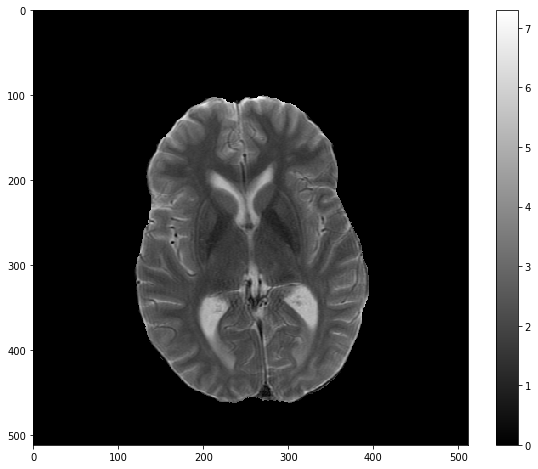

In [8]:
plt.imshow(t2_proc[1, 168])
plt.colorbar()

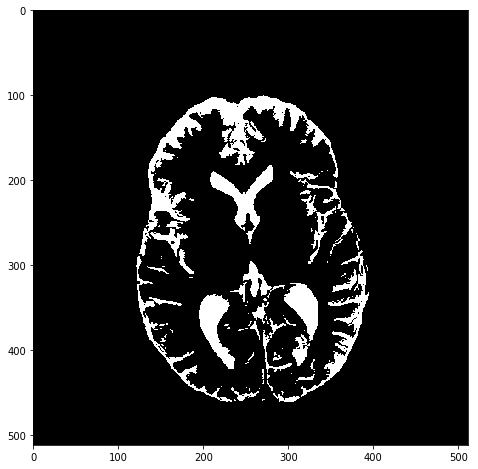

In [5]:
th = np.quantile(t2_proc[0], 0.9)
t2_th = t2_proc[0] >= th
t2m = (t2_proc[1] > 0.1)

plt.imshow(t2m[168] * t2_th[168])

In [14]:
h5_files = [f for f in glob('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/*.npy') if 'meta' not in f]
h5_cases = [f.split('/')[-1].replace('.npy', '') for f in h5_files]
print(len(h5_cases))

440


In [3]:
# cases = exp_utils.get_experiment_data('stanford_t2', '../configs/experiments/', dataset='test')
# cases = ['NO31', 'NO39', 'NO44', 'NO57', 'NO65']
cases = ['Brain2H-600441599']
base_path = '/home/srivathsa/projects/studies/gad/tiantan/data'
src_dir = lambda c: sorted([f for f in glob('{}/{}/*'.format(base_path, c)) if 'T2' not in f and 'FLAIR' not in f])[0]

for case in cases:
    dcm_ref = src_dir(case)
    dcm_ref_vol = get_dicom_vol(dcm_ref)
#     t2_data = np.load('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/{}.h5'.format(case))[0, :, 3]
    t2_data = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_fl/{}.h5'.format(case))[:, 3]
    t2_data = np.interp(t2_data, (t2_data.min(), t2_data.max()), (dcm_ref_vol.min(), dcm_ref_vol.max()))
    suio.write_dicoms(dcm_ref, t2_data, 
                      '/home/srivathsa/projects/studies/gad/tiantan/data/fl_reg_dcms/{}'.format(case), 
                      series_desc_pre='', series_desc_post='FL_REG')
    

100%|██████████| 196/196 [00:04<00:00, 39.58it/s]


In [2]:
cases = ['NO31', 'NO39', 'NO44', 'NO57', 'NO65']
base_path = '/home/srivathsa/projects/studies/gad/tiantan/data'
src_dir = lambda c: sorted([f for f in glob('{}/{}/*'.format(base_path, c)) if 'T2' not in f and 'FLAIR' not in f])[0]

for case in cases:
    dcm_ref = src_dir(case)
    dcm_ref_vol = get_dicom_vol(dcm_ref)
#     t2_data = np.load('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/{}.h5'.format(case))[0, :, 3]
    flair_data = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_fl/{}.h5'.format(case))
    flair_data = np.interp(flair_data, (flair_data.min(), flair_data.max()), (dcm_ref_vol.min(), dcm_ref_vol.max()))
    suio.write_dicoms(dcm_ref, flair_data, 
                      '/home/srivathsa/projects/studies/gad/tiantan/data/fl_reg_dcms/{}'.format(case), 
                      series_desc_pre='', series_desc_post='FLAIR_REG')

100%|██████████| 196/196 [00:04<00:00, 44.20it/s]


In [6]:
data = np.load('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0207.npy')

In [122]:
t1_low = data[0, :, 1]
t2_vol = data[0, :, 3]
t1_post = data[0, :, 2]
t1_pre = data[0, :, 0]
t2_hist1 = sup.scale_im(t1_low, t2_vol)
t2_hist2 = sup.scale_im(t1_post, t2_vol)

image intensity normalization
scaling done, 4.7 s
image intensity normalization
scaling done, 4.6 s


-1.1921000480651855 19.982648849487305
-0.7859316468238831 14.3590669631958


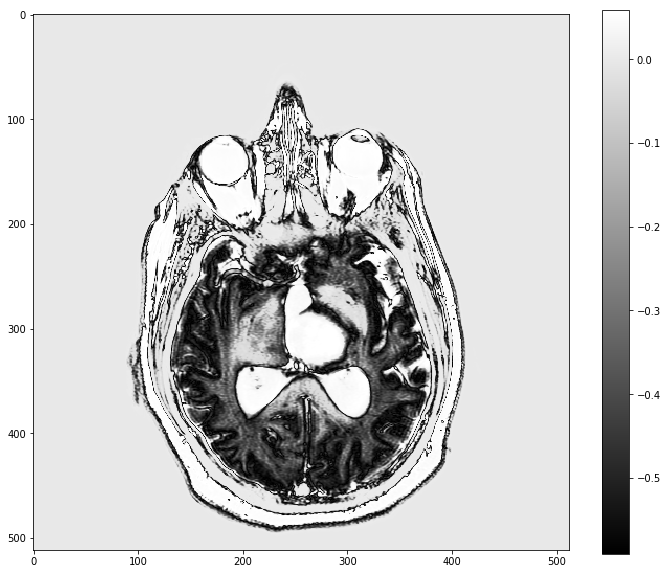

In [129]:
t2_hist1_sc = np.interp(t2_hist1, (t2_hist1.min(), t2_hist1.max()), (t1_post.min(), t1_post.max()))
plt.imshow(np.hstack([t1_post[167], t2_hist1[167], t2_hist1_sc[167]]))
print(t1_post.min(), t1_post.max())
print(t2_hist1.min(), t2_hist1.max())

-1.1921000480651855 19.982648849487305


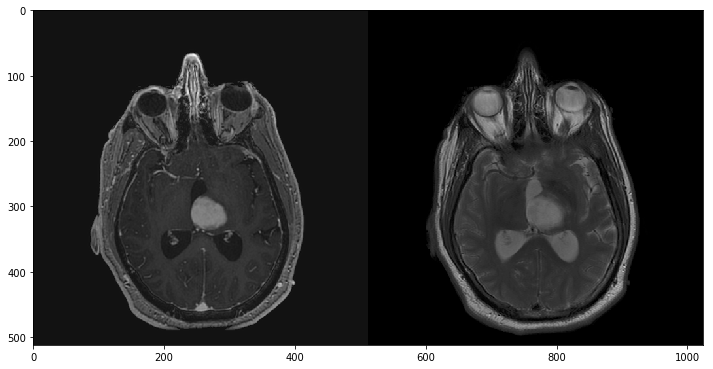

In [111]:
plt.imshow(np.hstack([t1_post[167], t2_hist2[167]]))

print(t2_hist2.min(), t2_hist2.max())

In [2]:
fpath_cases = sorted(glob('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/*'))
fpath_cases = [fpath for fpath in fpath_cases if 'meta' not in fpath]

stats_dict = []
for fpath in tqdm(fpath_cases, total=len(fpath_cases)):
    file_ext = '.' + fpath.split('/')[-1].split('.')[-1]
    data = suio.load_file(fpath, params={'h5_key': 'all'})
    
    stat = {
        '0_case': fpath.split('/')[-1].replace(file_ext, ''),
        '1_brain_zero_min': data[0, :, 0].min(),
        '2_brain_zero_max': data[0, :, 0].max(),
        '3_brain_low_min': data[0, :, 1].min(),
        '4_brain_low_max': data[0, :, 1].max(),
        '5_brain_full_min': data[0, :, 2].min(),
        '6_brain_full_max': data[0, :, 2].max(),
        '7_mask_zero_min': data[1, :, 0].min(),
        '8_mask_zero_max': data[1, :, 0].max(),
        '9_mask_low_min': data[1, :, 1].min(),
        '10_mask_low_max': data[1, :, 1].max(),
        '11_mask_full_min': data[1, :, 2].min(),
        '12_mask_full_max': data[1, :, 2].max()
    }
    
    stats_dict.append(stat)

In [3]:
df_stats = pd.DataFrame(stats_dict)
df_stats.to_csv('/home/srivathsa/projects/studies/gad/tiantan/data/scale_stats.csv')

In [7]:
q1 = np.array(df_stats['6_brain_full_max'])
q2 = np.array(df_stats['4_brain_low_max'])
diff = q1/q2

np.mean(diff)

1.110154096376065

In [7]:
data_new = np.load('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0086_sc.npy')

In [8]:
print(data_new[0, :, 3].min(), data_new[0, :, 3].max())
print(data_new[0, :, 2].min(), data_new[0, :, 2].max())

-0.58737174269557 12.118879817962647
-0.709097683429718 11.770586967468262


In [10]:
for fpath in glob('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/*_sc.npy'):
    os.rename(fpath, fpath.replace('_sc', ''))

In [7]:
proc_files = sorted([f for f in glob('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/*.h5') if 'meta' not in f])
t2_cases = []

for fpath_proc in tqdm(proc_files, total=len(proc_files)):
    d = suio.load_file(fpath_proc)
    if d.shape[1] == 4:
        t2_cases.append(fpath_proc.split('/')[-1].replace('.h5', ''))

In [8]:
t2_cases

['Brain2H-600441599',
 'Case1',
 'NO10',
 'NO11',
 'NO12',
 'NO13',
 'NO14',
 'NO15',
 'NO16',
 'NO17',
 'NO18',
 'NO19',
 'NO20',
 'NO21',
 'NO22',
 'NO23',
 'NO24',
 'NO25',
 'NO26',
 'NO27',
 'NO28',
 'NO29',
 'NO3',
 'NO30',
 'NO31',
 'NO32',
 'NO33',
 'NO34',
 'NO35',
 'NO36',
 'NO37',
 'NO38',
 'NO39',
 'NO4',
 'NO40',
 'NO41',
 'NO42',
 'NO43',
 'NO44',
 'NO45',
 'NO46',
 'NO47',
 'NO48',
 'NO49',
 'NO5',
 'NO50',
 'NO51',
 'NO52',
 'NO53',
 'NO54',
 'NO55',
 'NO56',
 'NO57',
 'NO58',
 'NO59',
 'NO6',
 'NO60',
 'NO61',
 'NO62',
 'NO63',
 'NO64',
 'NO65',
 'NO66',
 'NO67',
 'NO68',
 'NO69',
 'NO7',
 'NO70',
 'NO71',
 'NO72',
 'NO73',
 'NO74',
 'NO75',
 'NO76',
 'NO77',
 'NO78',
 'NO8',
 'NO9']

In [12]:
case_num = 'Case1'
base = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_fl'
data = suio.load_file('{}/{}.h5'.format(base, case_num), 
                      params={'h5_key': 'all'})
meta = suio.load_h5_metadata('{}/{}_meta.h5'.format(base, case_num))
t2_q = meta['t2_csf_quant']

slices = [71]
# t1_pre = data[1, :, 0]
# t1_post = data[1, :, 2]
# t2_full = data[0, :, 3]
# t2 = data[1, :, 3]

X_mask = []
Y_mask = []
X = []
for sl in slices:
    xm = data[1, sl-3:sl+4, [0, 1, 3]]
    X_mask.append(xm.transpose(1, 0, 2, 3))
    
    x = data[0, sl-3:sl+4, [0, 1, 3]]
    X.append(x.transpose(1, 0, 2, 3))
    
    ym = data[1, sl, 2][None, None, ...]
    Y_mask.append(ym)
    
X_mask = np.array(X_mask)
Y_mask = np.array(Y_mask)
X = np.array(X)
enh_mask = supre.get_enh_mask_t2(X_mask, Y_mask, X, center_slice=3, t2_csf_quant=t2_q)

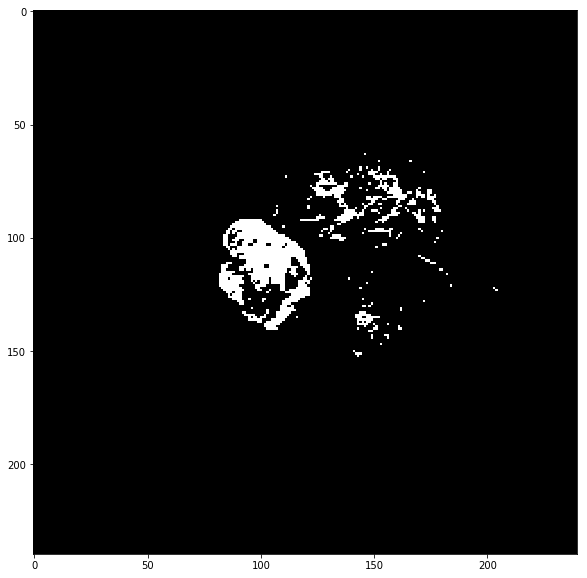

In [13]:
plt.imshow(enh_mask[0, 0, 0])
# plt.imshow(data[1, 71, 2])

In [11]:
fpath_gt = '/home/srivathsa/projects/studies/gad/tiantan/data/NO31/3DT1WMPRAGE_SAG_CS4_701'
fpath_gad = '/home/srivathsa/projects/studies/gad/tiantan/data/3aa100_aa734a/NO31/NO31_SubtleGad'
ref_fixed = supre.dcm_to_sitk(fpath_gt)
ref_moving = supre.dcm_to_sitk(fpath_gad)

gt = get_dicom_vol(fpath_gt)
gad = get_dicom_vol(fpath_gad)

gad = np.interp(gad, (gad.min(), gad.max()), (gt.min(), gt.max()))

In [15]:
pmap = sitk.GetDefaultParameterMap('affine')
gad_reg, _ = supre.register_im(gt, gad, param_map=pmap, im_fixed_spacing=np.array([1., 1., 1.]), 
                           im_moving_spacing=np.array([1., 1., 1.]), ref_fixed=ref_fixed, ref_moving=ref_moving)

image registration
registration done, 3.55 s


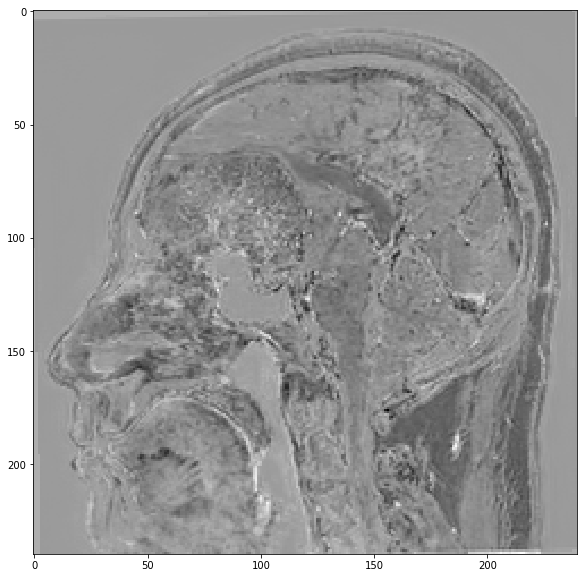

In [16]:
plt.imshow(gt[98]-gad_reg[98])

In [18]:
suio.write_dicoms(fpath_gt, gad_reg, 
                      '/home/srivathsa/projects/studies/gad/tiantan/data/3aa100_aa734a/NO31_reg', 
                      series_desc_pre='SubtleGad:', series_desc_post='enh_vgg_reg')

100%|██████████| 196/196 [00:04<00:00, 48.40it/s]
